# Quantum annealing time evolution
## Albert Molina

Here I will be coding my Hamiltonians and time evolution

In [1]:
import scipy as sp
import numpy as np
from scipy.sparse.linalg import eigsh, expm_multiply
import matplotlib.pyplot as plt
from src.hamiltonian_utils import FermiHubbardHamiltonian # the many-body Hamiltonian class
from src.nuclear_physics_utils import SingleParticleState,J2operator,get_twobody_nuclearshell_model # routines and class useful for the nuclear part

In [4]:
p_shell = 'data/cki'

SPS = SingleParticleState(file_name = p_shell)

# Let's print the single particle energies
print('single particle energies =', SPS.energies)
print('mapping between nucleon modes a and quantum numbers:', SPS.state_encoding)

nuc_modes_per_i = SPS.energies.shape[0] // 2   # counting per species!!

# Let's start with 8-Be (2 protons and 2 neutrons in p-shell):
p = 2
n = 2


single particle energies = [1.63 1.63 1.63 1.63 2.27 2.27 1.63 1.63 1.63 1.63 2.27 2.27]
mapping between nucleon modes a and quantum numbers: [(0, 1, 1.5, -1.5, 0.5, 0.5), (0, 1, 1.5, -0.5, 0.5, 0.5), (0, 1, 1.5, 0.5, 0.5, 0.5), (0, 1, 1.5, 1.5, 0.5, 0.5), (0, 1, 0.5, -0.5, 0.5, 0.5), (0, 1, 0.5, 0.5, 0.5, 0.5), (0, 1, 1.5, -1.5, 0.5, -0.5), (0, 1, 1.5, -0.5, 0.5, -0.5), (0, 1, 1.5, 0.5, 0.5, -0.5), (0, 1, 1.5, 1.5, 0.5, -0.5), (0, 1, 0.5, -0.5, 0.5, -0.5), (0, 1, 0.5, 0.5, 0.5, -0.5)]


Now, let us initialize our Target Hamiltonian $\rightarrow$ NSM Hamiltonian for $^{8}Be$

In [26]:
NSM_H = FermiHubbardHamiltonian(size_a=nuc_modes_per_i, size_b=nuc_modes_per_i, nparticles_a=p, nparticles_b=n, 
                                symmetries=[SPS.total_M_zero]) # we force M=0 so we don't get the full manybody basis
# Also, I changed Ema's code where a was neutrons and b protons, since they're just numbers (and the same in this case)

NSM_H.get_external_potential(external_potential=SPS.energies)
twobody_dict, _ = get_twobody_nuclearshell_model(file_name=p_shell)

NSM_H.get_twobody_interaction(twobody_dict)
NSM_H.get_hamiltonian() # Now we have the Target Hamiltonian ready

egs, psigs = NSM_H.get_spectrum(n_states=1) # just the ground state (energy in MeV's)
print(f'GS energy = {egs[0]:.5} MeV')
print(NSM_H.hamiltonian)


Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  8.10it/s]
1424it [00:02, 606.08it/s]

GS energy = -30.295 MeV
  (0, 0)	-6.582989999999999
  (0, 1)	2.002499032786363
  (0, 2)	-2.315995000000001
  (0, 3)	0.17580399459981977
  (0, 4)	-0.10150048360681718
  (0, 5)	-1.052265
  (0, 6)	1.9530200000000002
  (0, 8)	1.9009985491795476
  (0, 10)	2.002499032786366
  (0, 11)	-1.7096958900278656
  (0, 12)	-0.10150048360681718
  (0, 13)	0.5966341818903774
  (0, 14)	2.054162795550007
  (0, 15)	1.9530199999999995
  (0, 16)	-1.0522650000000002
  (0, 18)	-1.9009985491795478
  (0, 20)	-0.9007550000000002
  (0, 23)	0.17580399459982032
  (0, 24)	1.3652289845057242
  (0, 25)	0.5966341818903769
  (0, 26)	1.9009985491795474
  (0, 27)	-1.9009985491795478
  (0, 29)	-2.3986297010721485
  (1, 0)	2.002499032786363
  (1, 1)	-5.3826374999999995
  :	:
  (49, 49)	-3.0554875000000017
  (49, 50)	1.1102230246251565e-16
  (50, 9)	-3.763858685577873
  (50, 11)	-2.3986297010721485
  (50, 13)	0.5966341818903769
  (50, 14)	1.3652289845057242
  (50, 19)	3.763858685577873
  (50, 24)	2.054162795550007
  (50, 25)	0

Now, let's get our Driver Hamiltonian.

We have to consider the initial state, which in this case is the minimum energy Slater determinant.

In [ ]:
# We select the product state of the basis that minimizes the Hamiltonian
min = 10000
min_b = 0.

for i, b in enumerate(NSM_H.basis):
    psi = np.zeros(NSM_H.basis.shape[0]) # we initialize the state
    psi[i] = 1.0
    val = np.conj(psi) @ NSM_H.hamiltonian @ psi
    if val < min:
        min = val # Minimum energy!
        psi_base = psi 
        min_b = b
print(min_b) # THIS is the minimum energy Slater determinant

[1 0 0 1 0 0 1 0 0 1 0 0]


Then we define our external potential, following the description from the paper

In [28]:
ext_pot = np.zeros(2 * nuc_modes_per_i)
ext_pot = (min / (p + n)) * min_b

We can initialize our Driver Hamiltonian

In [30]:
Driver_H = FermiHubbardHamiltonian(size_a=nuc_modes_per_i, size_b=nuc_modes_per_i, nparticles_a=p, nparticles_b=n, 
                                   symmetries=[SPS.total_M_zero])
Driver_H.get_external_potential(ext_pot)
Driver_H.get_hamiltonian()
print(Driver_H.hamiltonian)

  (0, 0)	-7.702854999999998
  (1, 1)	-7.702854999999998
  (2, 2)	-7.702854999999998
  (3, 3)	-3.851427499999999
  (4, 4)	-7.702854999999998
  (5, 5)	-15.405709999999996
  (6, 6)	-7.702854999999998
  (7, 7)	-7.702854999999998
  (8, 8)	-7.702854999999998
  (9, 9)	-7.702854999999998
  (10, 10)	-7.702854999999998
  (11, 11)	-7.702854999999998
  (12, 12)	-7.702854999999998
  (13, 13)	-3.851427499999999
  (14, 14)	-7.702854999999998
  (15, 15)	-7.702854999999998
  (20, 20)	-7.702854999999998
  (21, 21)	-7.702854999999998
  (22, 22)	-3.851427499999999
  (23, 23)	-3.851427499999999
  (25, 25)	-3.851427499999999
  (26, 26)	-7.702854999999998
  (31, 31)	-7.702854999999998
  (32, 32)	-7.702854999999998
  (33, 33)	-7.702854999999998
  (38, 38)	-3.851427499999999
  (39, 39)	-3.851427499999999
  (41, 41)	-7.702854999999998
  (42, 42)	-7.702854999999998
  (43, 43)	-3.851427499999999
  (44, 44)	-7.702854999999998
  (45, 45)	-7.702854999999998
  (46, 46)	-7.702854999999998


Now, let's perform the adiabatic evolution

(100, 51, 6)
-30.291376100358363


c:\Users\alber\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


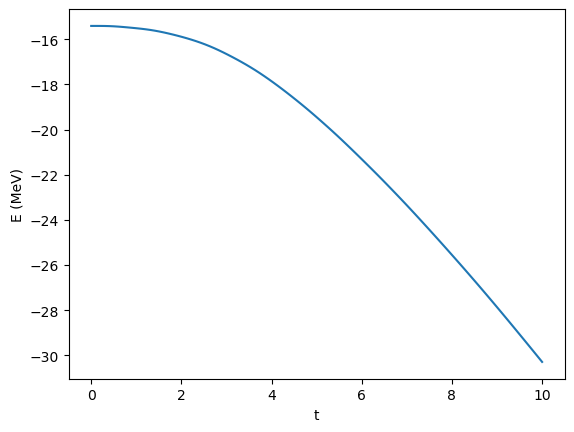

In [45]:
tf = 10
tsteps = 100
dt = tf / tsteps
time = np.linspace(0, tf, tsteps)

psi = psi_ini.copy()
energy = []
spectrum_t = []

for i, t in enumerate(time):
    H_t = (1 - t/tf) * Driver_H.hamiltonian + (t/tf) * NSM_H.hamiltonian
    energy.append(psi.conjugate().transpose().dot(H_t.dot(psi))) # we append <psi|H(t)|psi>
    eigvec, eigval = eigsh(H_t)
    spectrum_t.append(eigval)
    psi = expm_multiply(-1j * dt * H_t,psi)
spectrum_arr = np.asarray(spectrum_t)
print(spectrum_arr.shape)

# We plot the energy along time
plt.figure()
plt.plot(time, energy)
plt.xlabel('t')
plt.ylabel('E (MeV)')
print(np.real(energy[tsteps-1]))

We see that the energy at the end of the process is the same as the GS energy of the NSM $\rightarrow$ well executed!